# Localizing Multiple Cells Using LodeSTAR

This notebook provides you with a complete code example that trains a convolutional neural network to detect cells using a single crop of a cell and, then, it evaluates the performance of the trained network on all the images available in the sequence.


## Using the Cell Tracking Challenge Dataset

You’ll use a dataset from the Cell Tracking Challenge, which includes a series of videos of proliferating mouse hematopoietic stem cells. Even though
you don’t need ground truth positions to train the neural network, you can use the annotations provided for the challenge to evaluate the detection performance of your trained network.

Download the BF-C2DL-HSC dataset of the Cell Tracking Challenge ...


In [1]:
import os
from torchvision.datasets.utils import download_url, _extract_zip

dataset_path = os.path.join(".", "cell_detection_dataset")
if not os.path.exists(dataset_path):
    url = ("http://data.celltrackingchallenge.net/training-datasets/"
           "BF-C2DL-HSC.zip")
    download_url(url, ".")
    _extract_zip("BF-C2DL-HSC.zip", dataset_path, None)
    os.remove("BF-C2DL-HSC.zip")

dir = os.path.join(dataset_path, "BF-C2DL-HSC")

... create the pipeline to load the images and the relative ground truth cell positions ...


In [2]:
import glob
import deeptrack as dt
from skimage.measure import regionprops

sources = dt.sources.Source(
    image_path = sorted(glob.glob(os.path.join(dir, "02", "*.tif"))),
    label_path = sorted(glob.glob(os.path.join(dir, "02_GT", "TRA", "*.tif"))),
)

image = dt.LoadImage(sources.image_path)[:, :300] / 256
label = dt.LoadImage(sources.label_path)[:, :300] >> regionprops

pipeline = image & label

/opt/homebrew/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.16.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure yo

... and plot some images with the cell ground truth positions.


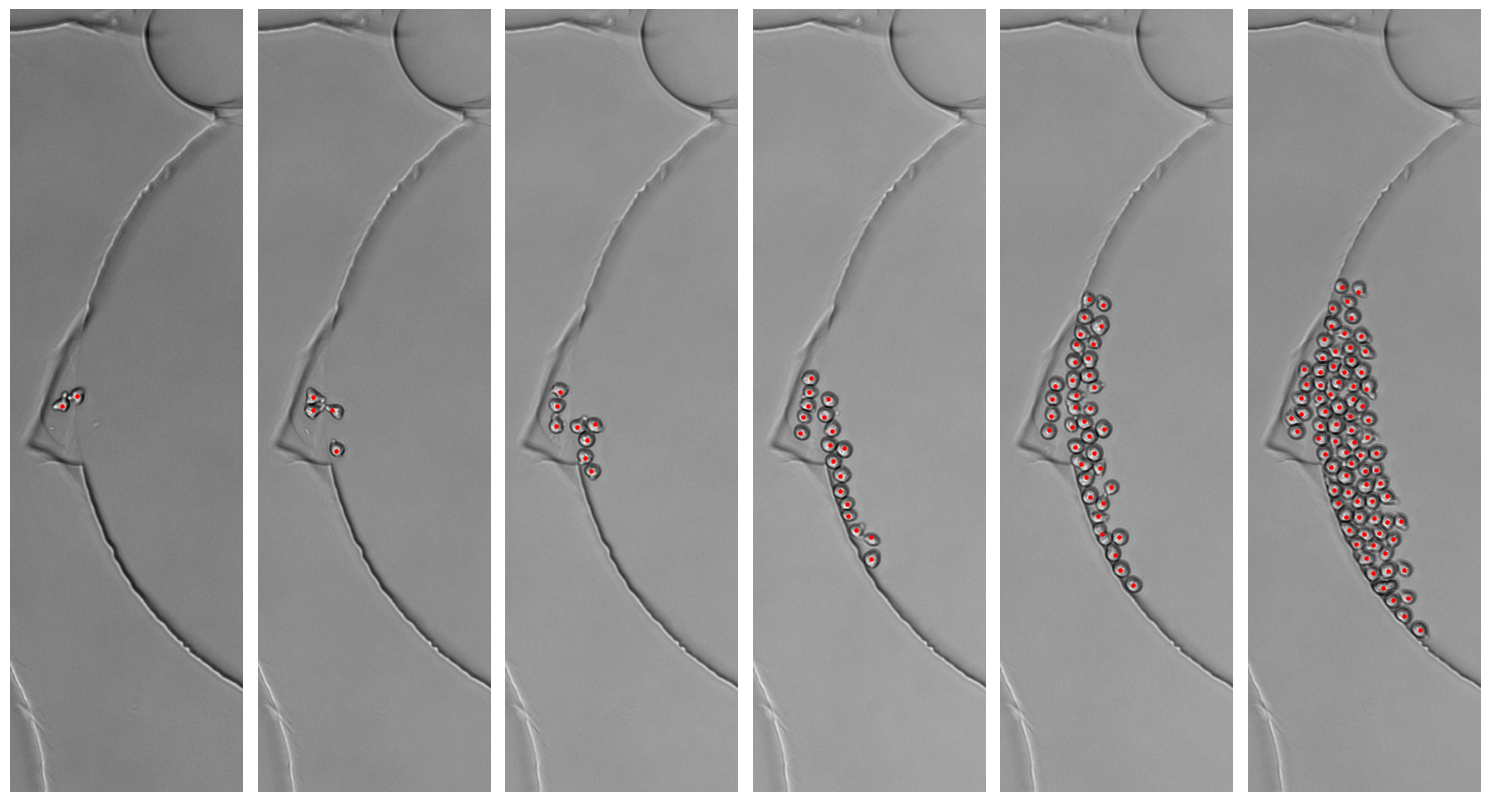

In [3]:
import matplotlib.pyplot as plt
import skimage.io

plt.figure(figsize=(15, 10))

for plt_index, data_index in enumerate([0, 300, 600, 900, 1200, 1500]):
    image, *props = pipeline(sources[data_index])

    plt.subplot(1, 6, plt_index + 1)
    plt.imshow(image, cmap="gray")
    for prop in props:
        plt.scatter(prop.centroid[1], prop.centroid[0], s=5, color="red")
    plt.axis("off")

plt.tight_layout()

## Preparing the Training Crop

Prepare the training crop ...


In [4]:
import matplotlib.patches as patches

crop_frame_index = 282
crop_size = 50
crop_x0, crop_y0 = 595 - crop_size // 2, 115 - crop_size // 2

image, *props = pipeline(sources[crop_frame_index])
crop = image[crop_x0:crop_x0 + crop_size, crop_y0:crop_y0 + crop_size]

... and plot it.


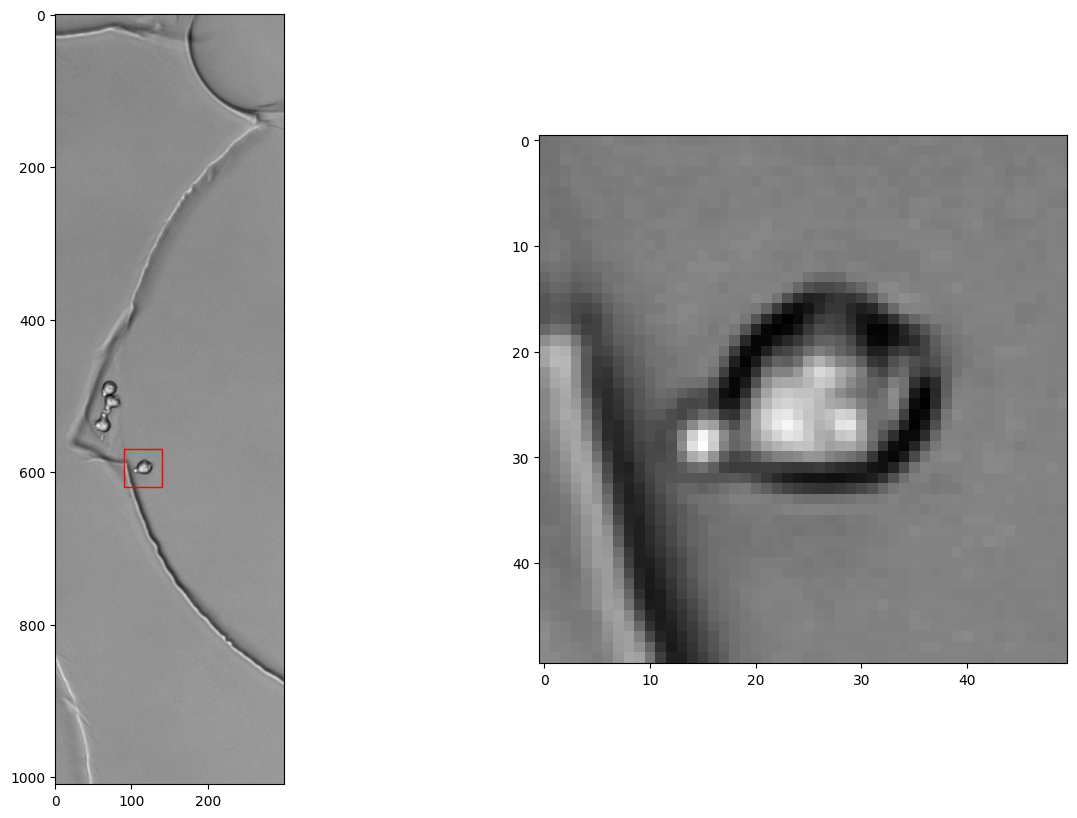

In [5]:
import matplotlib.patches as patches

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.gca().add_patch(patches.Rectangle((crop_y0, crop_x0), crop_size, crop_size,
                                      linewidth=1, edgecolor="r",
                                      facecolor="none"))

plt.subplot(1, 2, 2)
plt.imshow(crop, cmap="gray")

plt.show()

## Creating the Training Pipeline and Data Loader

Create the training pipeline ...


In [6]:
import numpy as np
import torch

training_pipeline = (
    dt.Value(crop)
    >> dt.Multiply(lambda: np.random.uniform(0.9, 1.1))
    >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
    """ Different augmentations are added, but not transformations that would change the positions of the cell """
)

... and the dataset and data loader.


In [7]:
import deeplay as dl

training_dataset = dt.pytorch.Dataset(training_pipeline, length=400,
                                      replace=False)
dataloader = dl.DataLoader(training_dataset, batch_size=8, shuffle=True)

## Training the Neural Network

Define and train the LodeSTAR neural network ...


In [8]:
# change device to mps

lodestar = dl.LodeSTAR(n_transforms=4, optimizer=dl.Adam(lr=1e-4)).build()
trainer = dl.Trainer(max_epochs=200)
trainer.fit(lodestar, dataloader)

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:454: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO: 
  | Name          | Type                       | Params
-------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K 
1 | between_loss  | L1Loss                     | 0     
2 | within_loss   | L1Loss                     | 0     
3 | train_metrics | MetricCollection           | 0     
4 | val_metrics   | MetricCollection           | 0     
5 | test_metrics  | MetricCollection           | 0     
6 | optimizer     | Adam                       | 0     
-------------------------------------------------------------
251 K     Trainable p

Training: |          | 0/? [00:00<?, ?it/s]

... and plot its predictions.


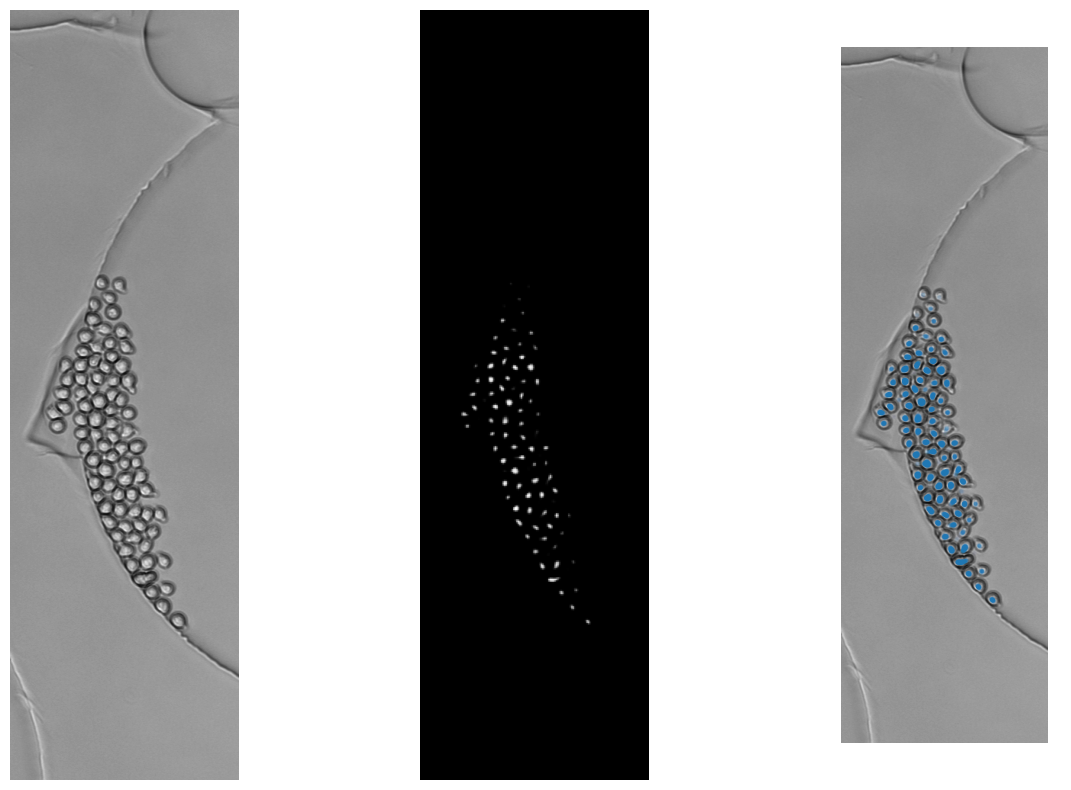

In [9]:
image_index = 1500
image, *props = pipeline(sources[image_index])
torch_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
prediction = lodestar(torch_image)[0].detach().numpy()
x, y, rho = prediction[0], prediction[1], prediction[-1]

plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(rho, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(image, cmap="gray")
plt.scatter(y.flatten(), x.flatten(), alpha=rho.flatten() / rho.max(), s=5)
plt.axis("off")

plt.show()

## Evaluating the Performance of the Trained Network

Fix the parameters to determine the positions of the cells in the images ...


In [10]:
alpha = 0.2
beta = 1 - alpha
cutoff = 0.2
mode = "constant"

... determine and plot the positions of the cells in the images ...


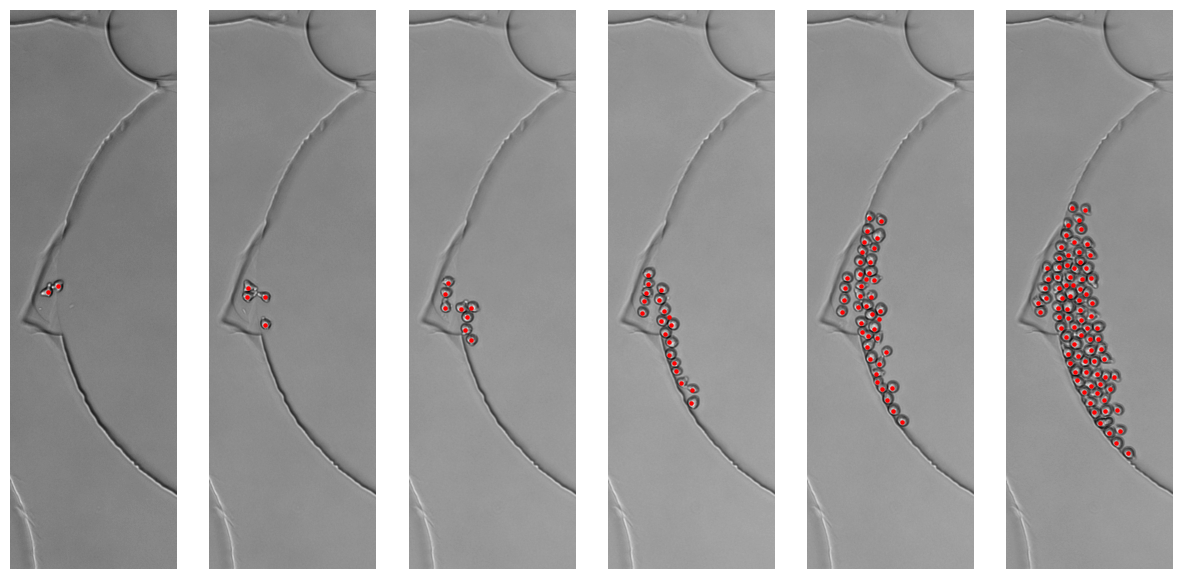

In [11]:
plt.figure(figsize=(15, 10))

for plot_idx, frame_idx in enumerate([0, 300, 600, 900, 1200, 1500]):
    image, *props = pipeline(sources[frame_idx])
    torch_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
    detections = lodestar.detect(torch_image, alpha=alpha, beta=beta,
                                 mode="constant", cutoff=cutoff)[0]
    
    plt.subplot(1, 6, plot_idx + 1)
    plt.imshow(image, cmap="gray")
    plt.scatter(detections[:, 1], detections[:, 0], s=5, color="red")
    plt.axis("off")

plt.show()

... and calculate the F1-score to quantify the neural network performance.


In [13]:
import tqdm 
import scipy

distance_th = 10

TP, FP, FN = 0, 0, 0
for source in tqdm.tqdm(sources[::10]):
    image, *props = pipeline(source)
    torch_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
    detections = lodestar.detect(torch_image, alpha=alpha, beta=beta,
                              mode="constant", cutoff=cutoff)[0]
    centroids = np.array([prop.centroid[:2] for prop in props])

    distance_matrix = scipy.spatial.distance_matrix(detections, centroids)
    row_idx, col_idx = scipy.optimize.linear_sum_assignment(distance_matrix)

    filtered_row_ind = row_idx[distance_matrix[row_idx, col_idx] < distance_th]
    filtered_col_ind = col_idx[distance_matrix[row_idx, col_idx] < distance_th]

    TP += len(filtered_row_ind)
    FP += len(detections) - len(filtered_row_ind)
    FN += len(centroids) - len(filtered_col_ind)

F1 = 2 * TP / (2 * TP + FP + FN)

print(f"""
TP: {TP}
FP: {FP}
FN: {FN}
F1: {F1}  
""")


100%|██████████| 177/177 [01:00<00:00,  2.90it/s]


TP: 6210
FP: 348
FN: 265
F1: 0.9529655489910228  

